In [1]:
import os

In [2]:
os.getcwd()

'/home/jovyan/workspace/parcels/parcels/examples/parcels_examples'

In [3]:
#os.chdir('/home/jovyan/workspace/bog') 
os.chdir('/home/jovyan/workspace/parcels/parcels/examples/parcels_examples')


In [4]:
os.getcwd()

'/home/jovyan/workspace/parcels/parcels/examples/parcels_examples'

In [5]:
%pip install -q cartopy
%pip install -q xarray
%pip install -q "xarray[io]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
from parcels import (
    AdvectionRK4,
    FieldSet, 
    JITParticle, 
    ParticleSet, 
    plotTrajectoriesFile, 
    Variable
)

In [6]:
!pip install eccodes==1.2.0

  Using cached eccodes-1.2.0-py3-none-any.whl (46 kB)


### Configure FieldSet

In [7]:
def config_fieldset(current_fname, temp_fname):
    '''
    Input: file path for data that simulates ocean environment
    Returns fieldset object of ocean parcels package
    '''
    filenames = {'U': current_fname, 'V': current_fname, 'T': temp_fname}
    variables = {'U': 'utotal', 'V': 'vtotal', 'T': 'thetao'}
    dimensions = {'U': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'depth': 'depth'},
                  'V': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'depth': 'depth'},
                  'T': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'depth': 'depth'}}
    fs = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=True)
    return fs

fieldset = config_fieldset(current_fname = 'Copernicus/currents/*.nc', \
                           temp_fname = 'Copernicus/temperature/*.nc')

### Generate Latitude and Longitude Coordinates

Different latitutde and logitude coordinates will be randomly generated for each of the 3 fisheries. These coordinate pairs will be used to initilalize the particleset object so that the intial coordinates of the particle, are always within the coordinates defined for a specific fishery.
Hence, for each fishery, there will be a separate randomisation function call to generate the initial particle coordinates within its own boundary

**Fishery 1 - Maine - 412 buoy**

Lat lb,ub = 43.96031, 49.237

Lon lb,ub = -68.12764, -58.327663

**Fishery 2 - Massachusetts - 2028 buoys**

Lat lb, ub = 37.34531, 39.18285

Lon lb, ub = -73.17786, -60.67709

**Fishery 3 - S Carolina - 27369 buoys**

Lat lb,ub = 31.891788, 33.98395

Lon lb,ub = -77.57924, -75.516266

In [8]:
import random

def gen_particle_fishery(lat_lb, lat_ub, lon_lb, lon_ub, n_particles):
    '''
    For a given fishery, returns 2 lists (size = num_particles) of 
    particle starting lat and lon bounded by lower & upper bounds.
    '''
    lat_lst = [random.uniform(lat_lb, lat_ub) for _ in range(n_particles)]
    lon_lst = [random.uniform(lon_lb, lon_ub) for _ in range(n_particles)]
    
    return lat_lst, lon_lst
    

In [9]:
maine_lat, maine_lon = gen_particle_fishery(43.96031, 49.237, -68.12764, -58.327663, n_particles=500)
mass_lat, mass_lon = gen_particle_fishery(37.34531, 39.18285, -73.17786, -60.67709,n_particles=500)
lawrence_lat, lawrence_lon = gen_particle_fishery(31.891788, 33.98395, -77.57924, -75.516266, n_particles=500)

### Configure ParticleSet

In [10]:
def config_pset_fishery(lat_lst_fishery, lon_lst_fishery, fieldset):
    '''
    For a given fishery, releases list of particles with
    starting lat and lon positions into fieldset
    Returns: ParticleSet object of ocean parcels package
    '''
    # Define a new particle class
    class AgeParticle(JITParticle):        # It is a JIT particle
        age = Variable('age',
                       initial=0)          # Variable 'age' is added with initial value 0.

    pset = ParticleSet(fieldset=fieldset,
                       pclass=AgeParticle,
                       lat=lat_lst_fishery,
                       lon=lon_lst_fishery              
                       )
    return pset

pset_f1_maine = config_pset_fishery(maine_lat, maine_lon, fieldset)
pset_f2_mass = config_pset_fishery(mass_lat, mass_lon, fieldset)
pset_f3_lawrence = config_pset_fishery(lawrence_lat, lawrence_lon, fieldset)

### Configure Kernels

This custom kernel will keep track of the particle age. Particle age is computed in minutes, hence divided by 3600, because dt will be specified in seconds.

In [11]:
def Age(particle, fieldset, time):
    '''
    Tracks age of all particles in pset
    by incrementing age argument by amount of 'dt' interval
    everytime the particle is "moved" in the simulation
    '''
    particle.age += particle.dt / 3600

A custom kernel (Age) and an ootb kernel (AdvectionRK4) are executed on pset of each fishery. As mentioned above, Age kernel is responsible for incrementing the particle's age (duration of existence across the simulation). The ootb Advection kernel is responsible for physically moving all particles in a given pset from their initial latitude and longitude, to a new latitude and longitude location. Till when should the Advection kernel keep moving the particle? That comes under "Run Simulation" header of notebook where we implement the simulation using pset.execute() method.

In [12]:
kernels_f1_maine = pset_f1_maine.Kernel(Age) + AdvectionRK4
kernels_f2_mass = pset_f2_mass.Kernel(Age) + AdvectionRK4
kernels_f3_lawrence = pset_f3_lawrence.Kernel(Age) + AdvectionRK4

### Run Simulation

Simulation is run for every fishery separately. 

pset.ParticleFile() method will create an output folder using the argument 'name' inside your working directory with sub-folders inside it that contain data about the trajectory of the particle when it moves in the simulation. 

Note: 'outputdt' argument in ParticleFile method can be different from 'dt' argument in Age object instantiated above, which means that particle can be moved at a different intervals of time in simulation, than whats shown in output.

In [13]:
output_f1_maine = pset_f1_maine.ParticleFile(name="copernicus_f1_maine.zarr", outputdt=3600) 

pset_f1_maine.execute(kernels_f1_maine, # the kernel (which defines how particles move)
             runtime=86400*24,        # the total length of the run in seconds (24 days)
             dt=60,                  # the timestep of the kernel in seconds
             output_file=output_f1_maine)

output_f2_mass = pset_f2_mass.ParticleFile(name="copernicus_f2_mass.zarr", outputdt=3600) 

pset_f2_mass.execute(kernels_f2_mass, # the kernel (which defines how particles move)
             runtime=86400*24,        # the total length of the run in seconds (24 days)
             dt=60,                  # the timestep of the kernel in seconds
             output_file=output_f2_mass)

# output_f3_lawrence = pset_f3_lawrence.ParticleFile(name="copernicus_f3_lawrence.zarr", outputdt=3600) 

# pset_f3_lawrence.execute(kernels_f3_lawrence, # the kernel (which defines how particles move)
#              runtime=86400*24,        # the total length of the run in seconds (24 days)
#              dt=60,                  # the timestep of the kernel in seconds
#              output_file=output_f3_lawrence)


INFO: Compiled ArrayAgeParticleAgeAdvectionRK4 ==> /tmp/parcels-1000/libfbdbab0755990f2c71ab0afdaad25c69_0.so
INFO: Output files are stored in copernicus_f1_maine.zarr.
100%|██████████| 2073600.0/2073600.0 [00:32<00:00, 64299.75it/s] 
INFO: Compiled ArrayAgeParticleAgeAdvectionRK4 ==> /tmp/parcels-1000/libf75124b8904b1caf8ad66f54945fe062_0.so
INFO: Output files are stored in copernicus_f2_mass.zarr.
100%|██████████| 2073600.0/2073600.0 [00:30<00:00, 68152.04it/s] 


### Plot Output Trajectories and Extract Synthetic Data

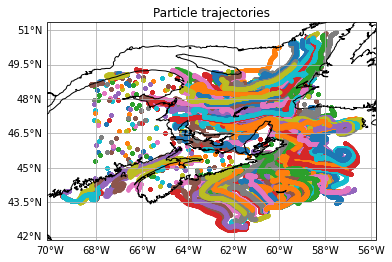

In [14]:
# Maine Fishery particles trajectory
plotTrajectoriesFile('copernicus_f1_maine.zarr');

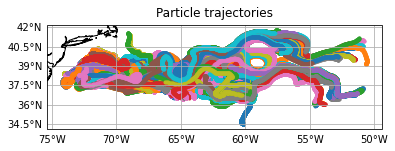

In [15]:
# Massachusettes Fishery particle trajectory
plotTrajectoriesFile('copernicus_f2_mass.zarr');

### Extract Data for Model

In [16]:
# Maine
data_xarray_maine = xr.open_zarr('copernicus_f1_maine.zarr')
display(data_xarray_maine)

<xarray.Dataset>
Dimensions:     (trajectory: 500, obs: 577)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 569 570 571 572 573 574 575 576
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(500, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

In [8]:
len(data_xarray_maine['lon'])

500

In [17]:
# Massachusettes
data_xarray_mass = xr.open_zarr('copernicus_f2_mass.zarr')
display(data_xarray_mass)

<xarray.Dataset>
Dimensions:     (trajectory: 500, obs: 577)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 569 570 571 572 573 574 575 576
  * trajectory  (trajectory) int64 500 501 502 503 504 ... 995 996 997 998 999
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
    lat         (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(500, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(500, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

In [18]:
def generate_output(df_xarray, fishery):
    traj_lst = []
    x_lst = []
    y_lst = []
    t_lst = []
    fishery_id = []
    for i in range(500):
        fishery_id.append(fishery)
        traj_lst.append(df_xarray['trajectory'].values[i])
        x_lst.append(df_xarray['lon'].values[i])
        y_lst.append(df_xarray['lat'].values[i])
        t_lst.append(df_xarray['time'].values[i])
    df_output = pd.DataFrame({'time': t_lst, 'lon': x_lst, 'lat': y_lst, 'trajectory_id': traj_lst, 'fishery_id':fishery_id})
    df_final = df_output.set_index(['trajectory_id']).apply(pd.Series.explode).reset_index()
    return df_final


In [19]:
df_mass_final  = generate_output(data_xarray_mass, 1)

In [ ]:
df_maine_final = generate_output(data_xarray_maine, 2) 

In [18]:
df_maine_final.to_csv('maine_data.csv')

In [10]:
df_mass_final.to_csv('mass_data.csv')